<h1 style = "font-size:3rem;color:darkcyan"> MFCC - Mel Frequency Cepstrum Coefficient</h1>

MFCC are often used for speaker/speech recognition. 

The timbre of speech is dependend on how it is filtered by the shape of the vocal tract (lips, tongue, nosal cavity, etc.). This shape is related to the envelope of the short time power spectrum, which can be represented by the mel frequency cepstrum coefficient (MFCC)

In [276]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy as sp
from scipy import signal

In [359]:
# import audio
signal , sample_rate = librosa.load('samples/Violin.wav')

<h3 style = "font-size:3rem;color:darkcyan">Mel-frequency</h3>
Short time fourier transform, or spectrogram, does not quite represent audio features as humans perceive them as.
Ideally we want to have audio features in which only the relevant information of both frequency and amplitude is presented. Meaning both frequnecy and amplitude should be represented logarithmically.

We can transform frequency in such a way that each step has the same perceptual distance by transforming it to Mel-frequency. 
calculation: $m = 2595 \cdot log(1 + \frac{f}{700})$


Text(0.5, 1.0, 'Zoomed In')

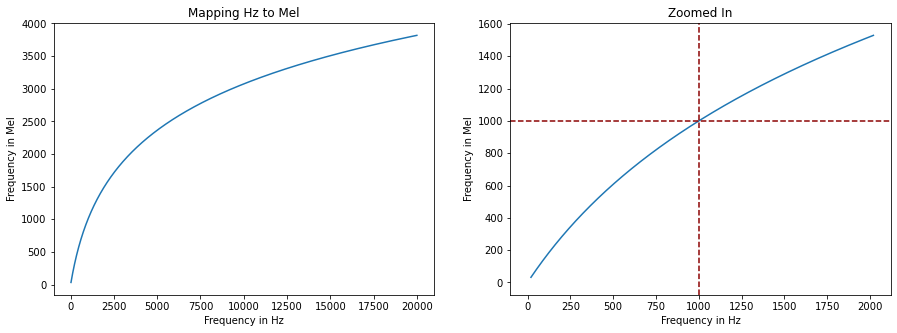

In [108]:
# Mapping:
f = np.arange(20,20000) # 20Hz to 20kHz
m = 2595 * np.log10(1 + f / 700)
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.plot(f,m)
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Mapping Hz to Mel')

plt.subplot(1,2,2)
plt.plot(f[:2000],m[:2000]) # zoomed in
plt.axline((1000,0),(1000,1000), linestyle ='--', color='darkred')
plt.axline((0,1000),(1000,1000), linestyle ='--', color='darkred')
plt.xlabel('Frequency in Hz')
plt.ylabel('Frequency in Mel')
plt.title('Zoomed In')

<h3 style = "font-size:3rem;color:darkcyan">Convert Spectrogram to Mel-frequency</h3>

1. choose number of mel bands
2. construct mel filter banks
3. apply filter banks to spectrogram

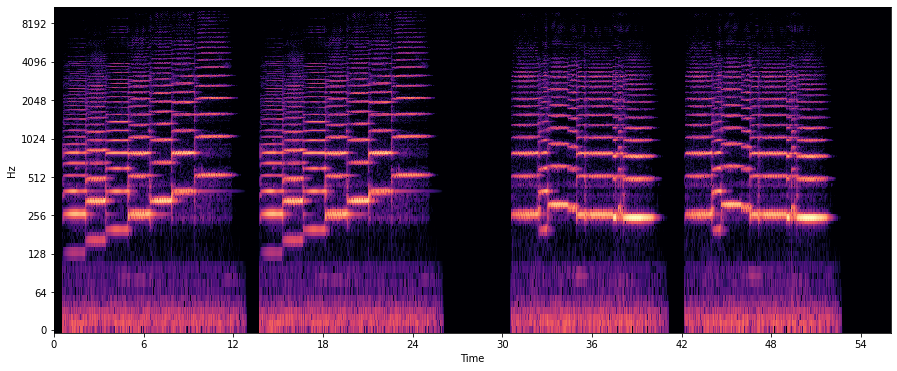

In [239]:
# Create spectrogram
plt.figure(figsize=(15, 6))
STFT = librosa.stft(signal, n_fft=2048) # return two vectors: magnitude and phase
STFT_db = librosa.amplitude_to_db(abs(STFT), ref=np.max)
img = librosa.display.specshow(STFT_db,
                                       y_axis='log',
                                       x_axis='time', 
                                       )

In [475]:
# Choose number of mel bands, often between 40 - 140
number_of_mel_bands = 20

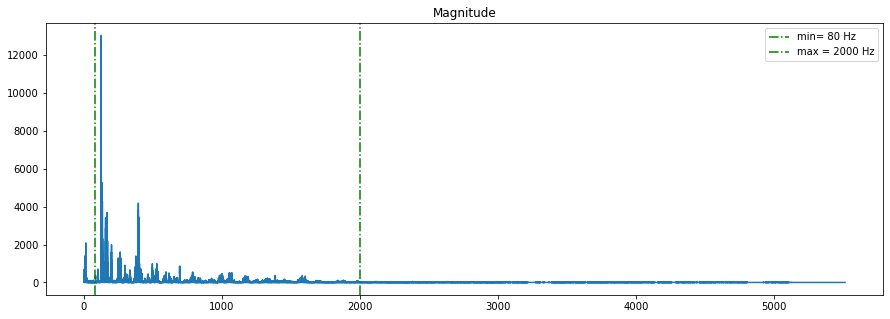

In [476]:
# Compute mel filter banks
# 1. Convert lowest and highest frequency to mel
# to check this see spectrum
#STFT = abs(np.fft.fft(signal))
#spec = librosa.display.specshow(DFT_mag)

plt.figure(figsize=(15,5))

N = len(signal)
DFT = np.fft.fft(signal)

f = np.linspace(1, sample_rate / 2, N) # convert to freq
plt.plot(f[:int(N/2) - 1], abs(DFT[:int(N/2) - 1]))
plt.title('Magnitude')
plt.axline((80,0),(80,1000), linestyle ='-.', color='green', label = 'min= 80 Hz')
plt.axline((2000,0),(2000,1000), linestyle ='-.', color='green', label = 'max = 2000 Hz')
plt.legend()

#: int(N/2) - 1


In [477]:
f_min = 80
f_max = 2000

m_min = 2595 * np.log10(1 + f_min / 700)
m_max = 2595 * np.log10(1 + f_max / 700)

In [478]:
# create # equally spaced bands:
mel_bands = np.linspace(m_min, m_max, number_of_mel_bands)
print(mel_bands)

[ 121.95608014  195.60889457  269.26170899  342.91452341  416.56733783
  490.22015225  563.87296667  637.5257811   711.17859552  784.83140994
  858.48422436  932.13703878 1005.7898532  1079.44266763 1153.09548205
 1226.74829647 1300.40111089 1374.05392531 1447.70673973 1521.35955416]


In [479]:
# convert points back to Hz
frequency_bands_target = 700 * (10**(mel_bands / 2595) - 1)
print(frequency_bands_target)


[  80.          132.6781912   188.91406424  248.94789121  313.03617128
  381.45272657  454.48987209  532.45966468  615.6952363   704.55221736
  799.41025615  900.67464098 1008.77803173 1124.1823085  1247.38054495
 1378.89911507 1519.29994209 1669.18289937 1829.18837343 2000.        ]


In [480]:
# round to nearest frequency bin as the signal is discrete
#frequency_bands = np.linspace(0, sample_rate /2 , len(STFT))
#plt.pcolormesh(STFT_db)

frequency_bands = librosa.fft_frequencies(sr=sample_rate, n_fft=2048)
print(frequency_bands)

matched_frequency_bands = np.zeros(number_of_mel_bands)
matched_frequency_index = np.zeros(number_of_mel_bands)
for i in range(0,number_of_mel_bands):
    matched_frequency_bands[i] = min(frequency_bands, key=lambda x:abs(x-frequency_bands_target[i]))
    matched_frequency_index[i], = np.where(frequency_bands == matched_frequency_bands[i])


[0.00000000e+00 1.07666016e+01 2.15332031e+01 ... 1.10034668e+04
 1.10142334e+04 1.10250000e+04]


Text(0.5, 0, 'Frequency in Mel')

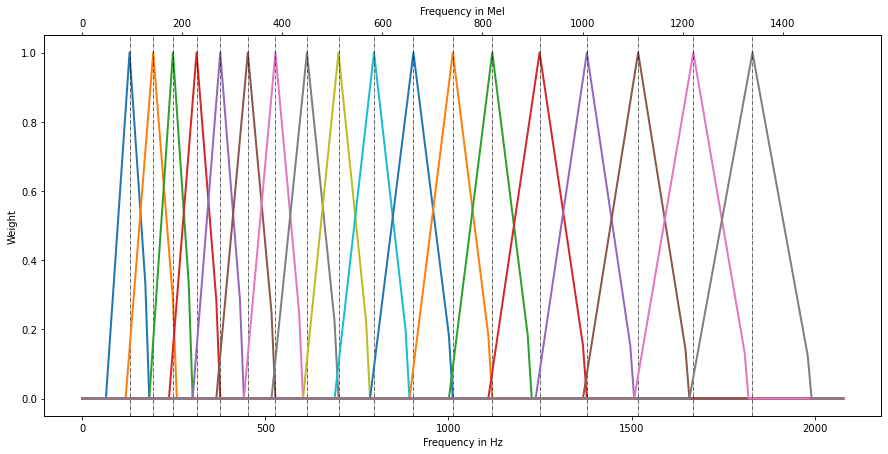

In [481]:
# create mel filter bank:
# triangular filters that ranges from previous center frequency to the next
max_index = matched_frequency_index[-1] + (np.round( (matched_frequency_index[-1] - matched_frequency_index[-2]) / 2))
windows = np.zeros((number_of_mel_bands, int(max_index)))

#plt.figure(figsize = (15,7))
fig = plt.figure(figsize = (15,7))
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

for i in range(1,number_of_mel_bands-1):
    # calculate range 
    window_length = 2 * int((matched_frequency_index[i] - matched_frequency_index[i - 1]))
    start = int(matched_frequency_index[i - 1])
    windows[i][start:start+window_length] = sp.signal.triang(window_length, False)
    
    # plot the window
    ax1.plot(frequency_bands[:int(max_index)], windows[i], lw = 2)
    ax1.axline((matched_frequency_bands[i],0),(matched_frequency_bands[i],1), linestyle ='-.', color='black', label = f'{matched_frequency_bands[i]} Hz', lw = 0.6)

ax1.set_ylabel('Weight')
ax1.set_xlabel('Frequency in Hz')

mel_spacing = np.linspace(0, int(mel_bands[-1]), 100)
ax2.plot(mel_spacing, np.ones(len(mel_spacing)), lw = 0) # Create a dummy plot
ax2.set_xlabel('Frequency in Mel')
#ax2.cla()


array([   0,  100,  200,  300,  400,  500,  600,  700,  800,  900, 1000,
       1100, 1200, 1300, 1400, 1500])

<h3 style = "font-size:3rem;color:darkcyan">Cepstrum</h3>
Speech can be seen as a combination of two processes: 

1. Larynx creating a pulse train, controling the pitch of your voice
2. Vocal tract (tongue, lips, cavities) that filters the sound

In the time signal these are convolved, so they both show up as the same spike in the frequency-domain when performing the fourier transform. For speeker identification you want to seperate these the vocal tract, as this information is more important for speech recognition. Cepstrum essentially differentiates the vocal tract from the larynx. Larynx will have a higher rate of change, or quefrency, as it changes faster than the vocal tract, that will have low quefrency. 

Cepstrum can be seen as the rate of change in spectral bands that is created by: 

1. Perform DFT on the time signal
2. Perform a transformation to seperate the larynx from the vocal tract. This is done by taking the log of the magnitude
3. Perform the inverse DFT to get the cepstrum


In [75]:
# import audio file
signal , sample_rate = librosa.load('samples/Violin.wav')
signal = signal[10000:101024]

#win_size = 1024
#signal = signal[10000:10000+win_size]
N = len(signal)


# take snippet

# take DFT of fragment

DFT = np.fft.fft(signal)

DFT_log_pow = np.log10(abs(DFT))

C = np.fft.ifft(DFT_log_pow)

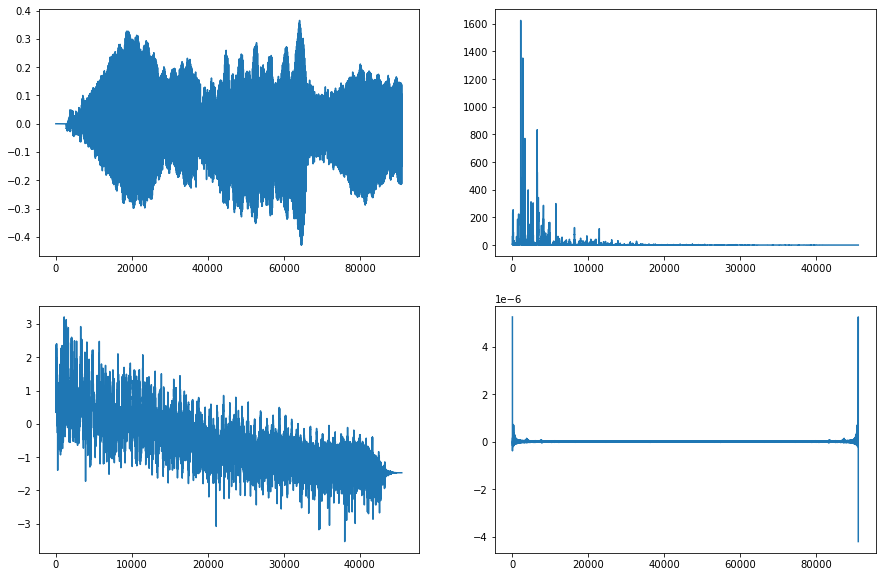

In [78]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.plot(signal)

plt.subplot(2,2,2)
plt.plot(abs(DFT[:int(np.round(N / 2) - 1)]))

plt.subplot(2,2,3)
plt.plot(DFT_log_pow[:int(np.round(N / 2) - 1)])

plt.subplot(2,2,4)
plt.plot(np.real(C[::-1] / N))


In [69]:
signal = signal[10000:101024]

N = len(signal)
print(N)
DFT = np.fft.fft(signal)

iDFT = np.fft.fft(DFT)

71024


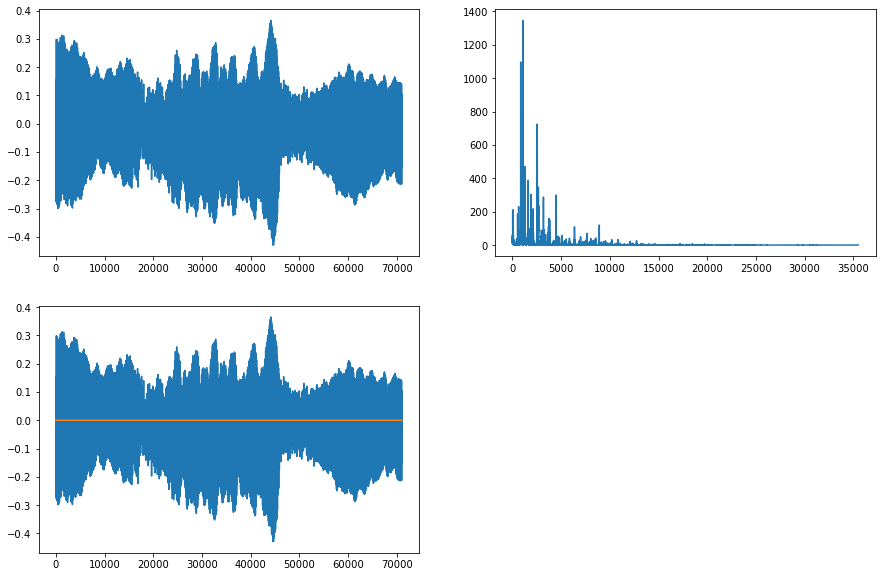

In [70]:
plt.figure(figsize = (15,10))
plt.subplot(2,2,1)
plt.plot(signal)

plt.subplot(2,2,2)

plt.plot(abs(DFT[:int(np.round(N / 2) - 1)]))

plt.subplot(2,2,3)
plt.plot(np.real(iDFT[::-1]) / N)
plt.plot(np.imag(iDFT))